My model is trained on the CIFAR10 small images classification dataset found in keras. Since the images found in the dataset are encoded as uint8, I first needed to change them in float32 objects. My model takes in 3D 32x32 images and converts them into 2D 28x28 images and predicts how images in the test set are classified in the 10 classes. I decided to create a network that takes in 32x32 images and compress them into 28x28 images. I repeatedly stacked MaxPooling2D layers and added Normalization layers after each convolutional layer to create a deeper architecture. This techinuque helps accelerate training by normalizing the inputs to each layer. I also included Dropout because I wanted to prevent overfitting since it randomly drops out neurons during training. Lastly, relu as my hidden layer activation function because non-linearity allows the model to learn complex patterns and there is no vanishing gradient when learning. Softmax is chosen as activation function for my output layer because the images are divided into several classes (10) which makes for a multi-class classification task.

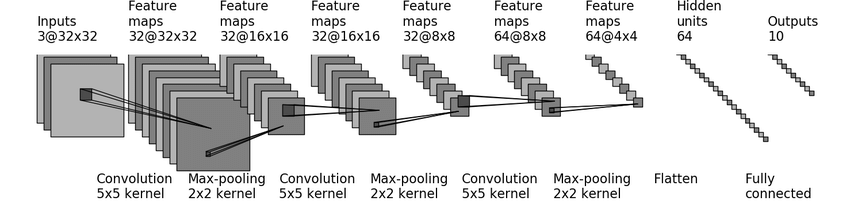

In [40]:
import tensorflow as tf
import tensorflow_datasets as tfds

Loading the CIFAR10 dataset which is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. I split the dataset into a train and test split.

In [41]:
(d_train, d_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Convert uint8 images into float32 images as the model expects float32.

In [42]:
def normalize_img(image, label):
  # Normalizes images: `uint8` -> `float32`
  return tf.cast(image, tf.float32) / 255., label

d_train = d_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
d_train = d_train.cache()
d_train = d_train.shuffle(ds_info.splits['train'].num_examples)
d_train = d_train.batch(128)
d_train = d_train.prefetch(tf.data.AUTOTUNE)

In [43]:
import numpy as np
np.array(list(d_train)[0][0]).shape

(128, 32, 32, 3)

In [44]:
np.array(list(d_train)[0][1])

array([5, 4, 5, 2, 8, 0, 8, 8, 9, 0, 3, 0, 7, 0, 3, 9, 1, 5, 4, 9, 8, 7,
       6, 0, 9, 4, 8, 7, 0, 3, 0, 5, 7, 4, 0, 2, 0, 6, 6, 1, 1, 3, 2, 3,
       3, 6, 8, 2, 7, 9, 5, 4, 8, 9, 2, 2, 7, 6, 3, 4, 9, 0, 5, 1, 9, 3,
       9, 6, 2, 1, 5, 8, 6, 3, 0, 8, 2, 3, 3, 3, 2, 9, 2, 4, 2, 0, 2, 1,
       6, 3, 8, 7, 0, 9, 7, 4, 3, 1, 2, 7, 2, 9, 4, 6, 9, 0, 1, 1, 2, 1,
       4, 5, 3, 4, 7, 5, 9, 2, 0, 7, 3, 6, 5, 6, 9, 7, 3, 5])

Plot of the first image in the data train set.

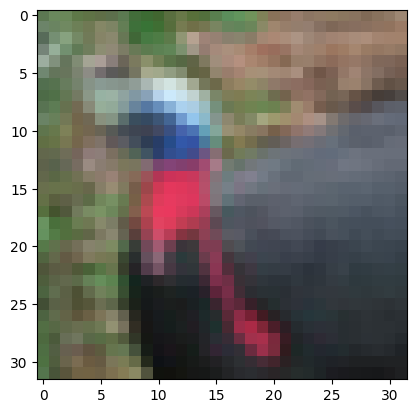

In [45]:
import matplotlib.pyplot as plt
plt.imshow(list(d_train)[0][0][0])

In [46]:
d_test = d_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
d_test = d_test.batch(128)
d_test = d_test.cache()
d_test = d_test.prefetch(tf.data.AUTOTUNE)

My model consists of 14 layers (2 hidden layers) and 1 output layer. My first layer is taking the 32x32 images and converting them into 2D images with a relu activation to prevent gradient vanishing. After that, BatchNormalization and MaxPooling2D are used to stabilize and accelerate training by normalizing the inputs to each layer and reduce the spatial resolution of the data, reducing the computational complexity and preventing overfitting. This pattern repeats for 3 times until I flatten the output of the previous layers, and then I add two fully connected Dense layers for further processing and eventually an output layer with 10 neurons (since it's a multi-class classification task with 10 classes) with the softmax activation function.

In [86]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

The chosen loss function is Sparse Categorical Crossentropy.This loss function is appropriate for multi-class classification problems where the target labels are provided as integers (sparse representation). During training, the Adam optimizer will adjust the model's weights to minimize the Sparse Categorical Crossentropy loss, aiming to improve the model's performance on the training data. The Sparse Categorical Accuracy metric will provide feedback on how well the model is doing in terms of correctly predicting the class labels during training and validation.

In [87]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [88]:
model.fit(
    d_train,
    epochs=10,
    validation_data=d_test,
)

Epoch 1/10
391/391 [==============================] - 126s 306ms/step - loss: 1.8164 - sparse_categorical_accuracy: 0.3480 - val_loss: 2.0874 - val_sparse_categorical_accuracy: 0.2655
Epoch 2/10
391/391 [==============================] - 113s 288ms/step - loss: 1.3744 - sparse_categorical_accuracy: 0.5110 - val_loss: 1.3185 - val_sparse_categorical_accuracy: 0.5182
Epoch 3/10
391/391 [==============================] - 118s 302ms/step - loss: 1.1790 - sparse_categorical_accuracy: 0.5916 - val_loss: 1.1948 - val_sparse_categorical_accuracy: 0.5848
Epoch 4/10
391/391 [==============================] - 111s 283ms/step - loss: 1.0490 - sparse_categorical_accuracy: 0.6380 - val_loss: 1.0464 - val_sparse_categorical_accuracy: 0.6368
Epoch 5/10
391/391 [==============================] - 111s 284ms/step - loss: 0.9524 - sparse_categorical_accuracy: 0.6737 - val_loss: 1.1381 - val_sparse_categorical_accuracy: 0.6027
Epoch 6/10
391/391 [==============================] - 111s 283ms/step - loss: 0.

In [89]:
loss, acc = model.evaluate(d_test)

79/79 [==============================] - 7s 85ms/step - loss: 0.8888 - sparse_categorical_accuracy: 0.7082


In [82]:
list(d_test)[0][1]

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([7, 0, 6, 9, 5, 1, 7, 0, 3, 2, 7, 2, 7, 9, 6, 8, 8, 8, 7, 9, 4, 2,
       3, 5, 0, 0, 2, 8, 1, 8, 2, 0, 7, 2, 0, 0, 9, 1, 0, 5, 1, 5, 0, 3,
       5, 0, 2, 0, 5, 3, 7, 4, 1, 4, 2, 5, 1, 5, 2, 0, 7, 2, 2, 1, 8, 5,
       3, 5, 3, 0, 6, 1, 5, 2, 8, 2, 5, 3, 0, 8, 8, 8, 6, 5, 8, 1, 9, 8,
       1, 3, 6, 0, 8, 7, 5, 3, 1, 8, 1, 4, 0, 8, 7, 3, 4, 1, 4, 3, 2, 2,
       1, 4, 7, 4, 9, 3, 4, 4, 2, 8, 1, 2, 8, 5, 2, 4, 0, 5])>

Plot of first image in the test set.

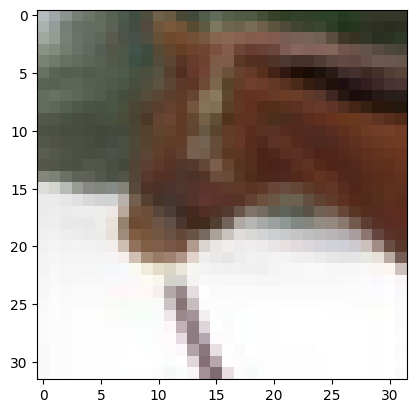

In [83]:
plt.imshow(list(d_test)[0][0][0])

In [84]:
model.predict(np.array(list(d_test)[0][0][0]).reshape(1, 32, 32, 3))

1/1 [==============================] - 0s 131ms/step


array([[0.00411815, 0.00138825, 0.05952669, 0.46323252, 0.10652531,
        0.18078648, 0.02246454, 0.15765823, 0.00306729, 0.00123255]],
      dtype=float32)

In [85]:
np.argmax(model.predict(np.array(list(d_test)[0][0][0]).reshape(1,32, 32, 3)))

1/1 [==============================] - 0s 35ms/step


3